In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import gzip
import matplotlib.pyplot as plt

f = gzip.GzipFile('data_processed.npy.gz', "r")
data = np.load(f, allow_pickle=True)
f.close()

In [2]:
f = gzip.GzipFile('results_processed.npy.gz', "r")
labels = np.load(f, allow_pickle=True)
f.close()

In [3]:
data = data[0:500000]
labels = labels[0:500000]
for i in range(len(labels)):
    labels[i] += 1

In [4]:
Xtr, Xts, ytr, yts = train_test_split(data, labels, test_size=0.10)
print("Xtr", Xtr.shape)
print("ytr", ytr.shape)
print("Xts", Xts.shape)
print("yts", yts.shape)

Xtr (450000, 768)
ytr (450000,)
Xts (50000, 768)
yts (50000,)


In [5]:
x_tr = torch.from_numpy(Xtr)
x_tr = x_tr.type(torch.FloatTensor)
y_tr = torch.from_numpy(ytr)
y_tr = y_tr.type(torch.LongTensor)
x_ts = torch.from_numpy(Xts)
x_ts = x_ts.type(torch.FloatTensor)
y_ts = torch.from_numpy(yts)
y_ts = y_ts.type(torch.LongTensor)

In [6]:
traindata = torch.utils.data.TensorDataset(x_tr, y_tr)
trainloader = torch.utils.data.DataLoader(
    traindata,
    batch_size = 100000
)

testdata = torch.utils.data.TensorDataset(x_ts, y_ts)
testloader = torch.utils.data.DataLoader(
    testdata,
    batch_size = 10000
)

In [7]:
n_in = 768
n_out = 3
learning_rate = 0.001
K = 770
epochs = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self, K, p):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, K) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(K, n_out)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization
        self.dropout = nn.Dropout(1-p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.dropout(x)
        return x

#criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [8]:
all_traccs = []
all_tsaccs = []
P = [1.0, 0.5, 0.1]
for p in P:
    net = Net(K, p).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    traccs = []
    tsaccs = []
    for epoch in range(epochs):
        correct = 0
        size = 0
        net.train()
        for b, (x, y) in enumerate(trainloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = net(x)
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            size += len(x)

        traccs.append((100 * correct) / size)
        net.eval()
        correct = 0
        size = 0
        with torch.no_grad():
            for b, (x, y) in enumerate(testloader):
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad() 
                output = net(x)
                #print(output)
                #acu += (output.argmax(1) == y).float().sum().item()
                cor = (output.argmax(1) == y).float().sum().item()

                correct += cor
                size += len(x)

            #accs.append(100 * (acu / len(y_tr)))
            tsaccs.append((100 * correct) / size)

        if ((epoch+1) % 10) == 0:
            print("Epoch: ", epoch+1)
    all_traccs.append(traccs)
    all_tsaccs.append(tsaccs)

C:\Users\Administrator\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80


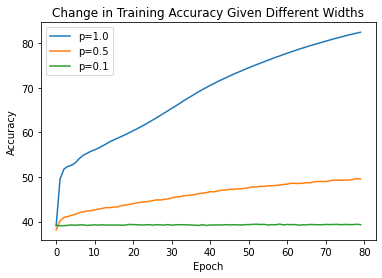

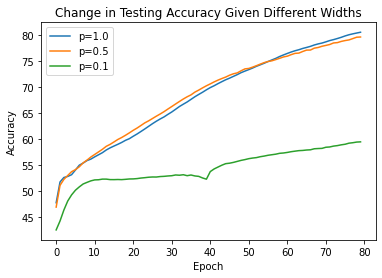

In [9]:
plt.figure(1)
for i, p in enumerate(P):
    plt.plot(all_traccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Training Accuracy')
plt.legend()
plt.show()

plt.figure(2)
for i, p in enumerate(P):
    plt.plot(all_tsaccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Testing Accuracy')
plt.legend()
plt.show()

In [10]:
for i in range(3):
    print('training p = ', P[i], max(all_traccs[i]))
    print('test p = ', P[i], max(all_tsaccs[i]))

p =  1.0 82.48
p =  1.0 80.546
p =  0.5 49.611111111111114
p =  0.5 79.628
p =  0.1 39.428666666666665
p =  0.1 59.432


In [11]:
#deep neural network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DeepNet(nn.Module):
    def __init__(self, p):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(n_in, 770) 
        torch.nn.init.kaiming_uniform_(self.fc1.weight) #He initialization
        self.fc2 = nn.Linear(770, 700)
        torch.nn.init.kaiming_uniform_(self.fc2.weight) #He initialization
        self.fc3 = nn.Linear(700, 600) 
        torch.nn.init.kaiming_uniform_(self.fc3.weight) #He initialization
        self.fc4 = nn.Linear(600, 500)
        torch.nn.init.kaiming_uniform_(self.fc4.weight) #He initialization
        self.fc5 = nn.Linear(500, 400) 
        torch.nn.init.kaiming_uniform_(self.fc5.weight) #He initialization
        self.fc6 = nn.Linear(400, 300)
        torch.nn.init.kaiming_uniform_(self.fc6.weight) #He initialization
        self.fc7 = nn.Linear(300, 200) 
        torch.nn.init.kaiming_uniform_(self.fc7.weight) #He initialization
        self.fc8 = nn.Linear(200, 100)
        torch.nn.init.kaiming_uniform_(self.fc8.weight) #He initialization
        self.fc9 = nn.Linear(100, 50) 
        torch.nn.init.kaiming_uniform_(self.fc9.weight) #He initialization
        self.fc10 = nn.Linear(50, n_out)
        torch.nn.init.kaiming_uniform_(self.fc10.weight) #He initialization
        self.dropout = nn.Dropout(1-p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.sigmoid(self.fc10(x))
        x = self.dropout(x)
        return x

In [12]:
all_deep_traccs = []
all_deep_tsaccs = []
for p in P:
    deepNet = DeepNet(p).to(device)
    optimizer = torch.optim.Adam(deepNet.parameters(), lr=learning_rate)
    deep_traccs = []
    deep_tsaccs = []
    for epoch in range(epochs):
        correct = 0
        size = 0
        deepNet.train()
        for b, (x, y) in enumerate(trainloader):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad() 
            output = deepNet(x)
            cor = (output.argmax(1) == y).float().sum().item()

            correct += cor
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            size += len(x)

        deep_traccs.append((100 * correct) / size)
        deepNet.eval()
        correct = 0
        size = 0
        with torch.no_grad():
            for b, (x, y) in enumerate(testloader):
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad() 
                output = deepNet(x)
                cor = (output.argmax(1) == y).float().sum().item()

                correct += cor
                size += len(x)

            deep_tsaccs.append((100 * correct) / size)

        if ((epoch+1) % 10) == 0:
            print("Epoch: ", epoch+1)
        
        
    all_deep_traccs.append(deep_traccs)
    all_deep_tsaccs.append(deep_tsaccs)

Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80


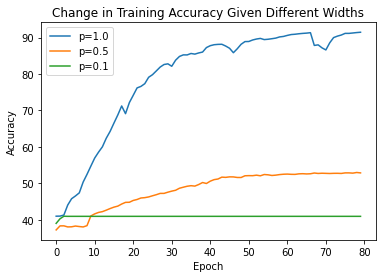

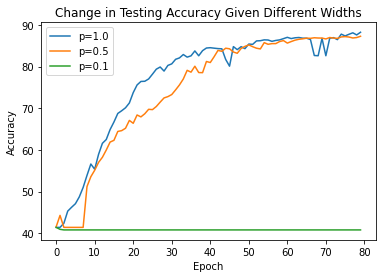

In [13]:
plt.figure(1)
for i, p in enumerate(P):
    plt.plot(all_deep_traccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Training Accuracy')
plt.legend()
plt.show()

plt.figure(2)
for i, p in enumerate(P):
    plt.plot(all_deep_tsaccs[i], label='p={}'.format(p))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Change in Testing Accuracy')
plt.legend()
plt.show()

In [14]:
for i in range(3):
    print('training p = ', P[i], max(all_deep_traccs[i]))
    print('test p = ', P[i], max(all_deep_tsaccs[i]))

p =  1.0 91.45377777777777
p =  1.0 88.256
p =  0.5 52.971111111111114
p =  0.5 87.288
p =  0.1 40.96666666666667
p =  0.1 41.406
